Lambda School Data Science

*Unit 2, Sprint 1, Module 4*

---

# Logistic Regression


## Assignment 🌯

You'll use a [**dataset of 400+ burrito reviews**](https://srcole.github.io/100burritos/). How accurately can you predict whether a burrito is rated 'Great'?

> We have developed a 10-dimensional system for rating the burritos in San Diego. ... Generate models for what makes a burrito great and investigate correlations in its dimensions.

- [ ] Do train/validate/test split. Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.
- [ ] Begin with baselines for classification.
- [ ] Use scikit-learn for logistic regression.
- [ ] Get your model's validation accuracy. (Multiple times if you try multiple iterations.)
- [ ] Get your model's test accuracy. (One time, at the end.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

- [ ] Add your own stretch goal(s) !
- [ ] Make exploratory visualizations.
- [ ] Do one-hot encoding.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Get and plot your coefficients.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Linear-Models/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
# Load data downloaded from https://srcole.github.io/100burritos/
import pandas as pd
df = pd.read_csv(DATA_PATH+'burritos/burritos.csv')

In [0]:
# Derive binary classification target:
# We define a 'Great' burrito as having an
# overall rating of 4 or higher, on a 5 point scale.
# Drop unrated burritos.
df = df.dropna(subset=['overall'])
df['Great'] = df['overall'] >= 4

In [0]:
# Clean/combine the Burrito categories
df['Burrito'] = df['Burrito'].str.lower()

california = df['Burrito'].str.contains('california')
asada = df['Burrito'].str.contains('asada')
surf = df['Burrito'].str.contains('surf')
carnitas = df['Burrito'].str.contains('carnitas')

df.loc[california, 'Burrito'] = 'California'
df.loc[asada, 'Burrito'] = 'Asada'
df.loc[surf, 'Burrito'] = 'Surf & Turf'
df.loc[carnitas, 'Burrito'] = 'Carnitas'
df.loc[~california & ~asada & ~surf & ~carnitas, 'Burrito'] = 'Other'

In [0]:
# Drop some high cardinality categoricals
df = df.drop(columns=['Notes', 'Location', 'Reviewer', 'Address', 'URL', 'Neighborhood'])

In [0]:
# Drop some columns to prevent "leakage"
df = df.drop(columns=['Rec', 'overall'])

In [149]:
# Take a look at the data
df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,NaN,NaN,x,x,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,NaN,NaN,NaN,x,x,NaN,NaN,NaN,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,NaN,NaN,x,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,NaN,NaN,x,x,NaN,x,x,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True


In [150]:
# There are some columns which represent some features of the burritos
# Their values are "x", "X", and NaNs
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Replace NaN with 0 and x with 1
cols = ['Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac',
       'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish',
       'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Queso',
       'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini']

for col in cols:
    df.loc[df[col].isnull(),col]=0
    df.loc[df[col]=='x',col]=1
    df.loc[df[col]=='X',col]=1

df.head()

,Burrito,Date,Yelp,Google,Chips,Cost,Hunger,Mass (g),Density (g/mL),Length,Circum,Volume,Tortilla,Temp,Meat,Fillings,Meat:filling,Uniformity,Salsa,Synergy,Wrap,Unreliable,NonSD,Beef,Pico,Guac,Cheese,Fries,Sour cream,Pork,Chicken,Shrimp,Fish,Rice,Beans,Lettuce,Tomato,Bell peper,Carrots,Cabbage,Sauce,Salsa.1,Cilantro,Onion,Taquito,Pineapple,Ham,Chile relleno,Nopales,Lobster,Queso,Egg,Mushroom,Bacon,Sushi,Avocado,Corn,Zucchini,Great
0,California,1/18/2016,3.5,4.2,NaN,6.49,3.0,NaN,NaN,NaN,NaN,NaN,3.0,5.0,3.0,3.5,4.0,4.0,4.0,4.0,4.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,False
1,California,1/24/2016,3.5,3.3,NaN,5.45,3.5,NaN,NaN,NaN,NaN,NaN,2.0,3.5,2.5,2.5,2.0,4.0,3.5,2.5,5.0,0,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,False
2,Carnitas,1/24/2016,NaN,NaN,NaN,4.85,1.5,NaN,NaN,NaN,NaN,NaN,3.0,2.0,2.5,3.0,4.5,4.0,3.0,3.0,5.0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,False
3,Asada,1/24/2016,NaN,NaN,NaN,5.25,2.0,NaN,NaN,NaN,NaN,NaN,3.0,2.0,3.5,3.0,4.0,5.0,4.0,4.0,5.0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,False
4,California,1/27/2016,4.0,3.8,x,6.59,4.0,NaN,NaN,NaN,NaN,NaN,4.0,5.0,4.0,3.5,4.5,5.0,2.5,4.5,4.0,0,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,True


In [151]:
# Take a look to other categorical variables
df.describe(exclude='number')

,Burrito,Date,Chips,Great
count,421,421,26,421
unique,5,169,4,2
top,California,8/30/2016,x,False
freq,169,29,21,239


In [152]:
# What are the values of Chips?
df['Chips'].value_counts()

x      21
X       3
No      1
Yes     1
Name: Chips, dtype: int64

In [0]:
# Replace "x", "X", "Yes" with 1 
# Replace "NaN" and "No" with 0
df.loc[df['Chips'].isnull(),'Chips']=0
df.loc[df['Chips']=='No','Chips']=1
df.loc[df['Chips']=='x','Chips']=1
df.loc[df['Chips']=='X','Chips']=1
df.loc[df['Chips']=='Yes','Chips']=1

### Train/validate/test split

Train on reviews from 2016 & earlier. Validate on 2017. Test on 2018 & later.

In [154]:
# check the data type of the column `Date`
df['Date'].dtypes

dtype('O')

In [155]:
# Convert the date from string into datetime format
df['Date'] = pd.to_datetime(df['Date'], infer_datetime_format=True)
df['Date'].dtypes

dtype('<M8[ns]')

In [156]:
# Split the data on train, validate and test data
train = df[df.Date < pd.to_datetime('01/01/2017')]
val = df[(df.Date >= pd.to_datetime('01/01/2017')) & (df.Date < pd.to_datetime('01/01/2018'))]
test = df[df.Date >= pd.to_datetime('01/01/2018')]

train.shape, val.shape, test.shape

((298, 59), (85, 59), (38, 59))

### Baselines for classification

In [157]:
# Determine majority class
target = 'Great'
y_train = train[target]
y_train.value_counts(normalize=True)

False    0.590604
True     0.409396
Name: Great, dtype: float64

In [158]:
# The majority class for every prediction
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)
pd.unique(y_pred), len(y_pred)

(array([False]), 298)

In [0]:
# Get the baseline accuracy for guessing the majority class for every prediction
from sklearn.metrics import accuracy_score

In [160]:
# Training accuracy
# It should be the same as the frequency of majority class
accuracy_score(y_train, y_pred)

0.5906040268456376

In [161]:
# Validation accuracy
y_val = val[target]
y_pred = [majority_class] * len(val)
accuracy_score(y_val, y_pred)

0.5529411764705883

### Scikit-learn for logistic regression

In [162]:
# Arrange X feature matrices and y target vectors
features = ['Burrito', 'Chips', 'Cost', 'Hunger',
       'Length', 'Circum', 'Volume', 'Tortilla',
       'Temp', 'Meat', 'Fillings', 'Meat:filling', 'Uniformity', 'Salsa',
       'Synergy', 'Wrap', 'Unreliable', 'NonSD', 'Beef', 'Pico', 'Guac',
       'Cheese', 'Fries', 'Sour cream', 'Pork', 'Chicken', 'Shrimp', 'Fish',
       'Rice', 'Beans', 'Lettuce', 'Tomato', 'Bell peper', 'Carrots',
       'Cabbage', 'Sauce', 'Salsa.1', 'Cilantro', 'Onion', 'Taquito',
       'Pineapple', 'Ham', 'Chile relleno', 'Nopales', 'Lobster', 'Queso',
       'Egg', 'Mushroom', 'Bacon', 'Sushi', 'Avocado', 'Corn', 'Zucchini']
target = 'Great'

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((298, 53), (298,), (85, 53), (85,))

In [0]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler

In [0]:
# Encode the categorical variables
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train_encoded = encoder.fit_transform(X_train)
X_val_encoded = encoder.transform(X_val)

# Impute values for NaNs
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train_encoded)
X_val_imputed = imputer.transform(X_val_encoded)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [165]:
# Apply the Logistic Regression
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

### Validation accuracy

In [166]:
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.7647058823529411


### Plot the coefficients

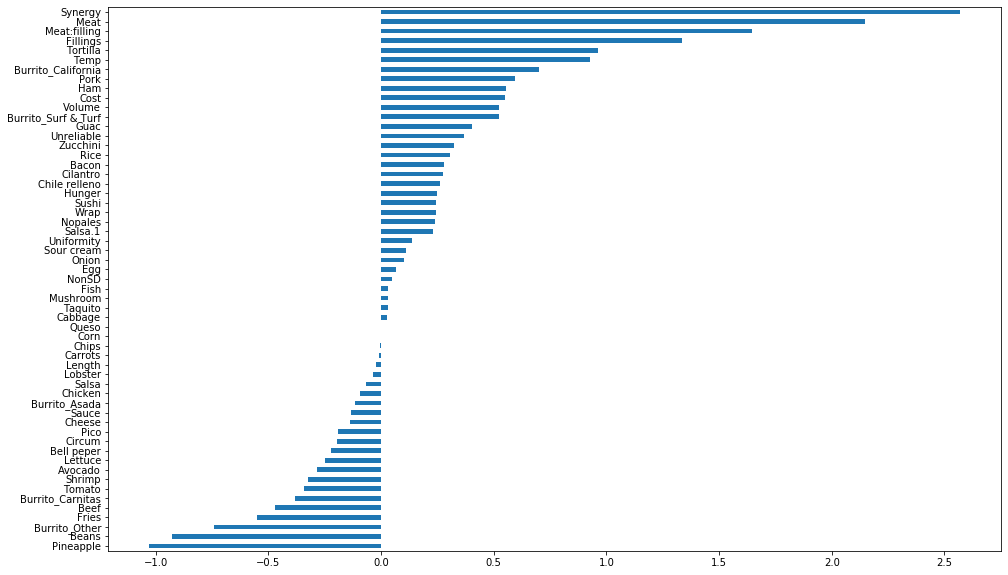

In [167]:
# Plot the coefficients:
import matplotlib.pyplot as plt
%matplotlib inline
coefficients = pd.Series(model.coef_[0], X_train_encoded.columns)
plt.figure(figsize=(16,10))
coefficients.sort_values().plot.barh();

### Improve the model by keeping only meaningful features
I will consider meaningful features those coefficients that have an absolute value greater than 0.5

In [168]:
# Get the coefficients which are greater than 0.5 or smaller than -0.5
coefficients[abs(coefficients)>=0.5]

Burrito_California     0.699088
Burrito_Other         -0.742491
Burrito_Surf & Turf    0.524466
Cost                   0.548967
Volume                 0.524581
Tortilla               0.963329
Temp                   0.926259
Meat                   2.146682
Fillings               1.334528
Meat:filling           1.647167
Synergy                2.570061
Fries                 -0.549019
Pork                   0.593272
Beans                 -0.927711
Pineapple             -1.030519
Ham                    0.556136
dtype: float64

In [169]:
# Save the list of the most meaningful features
best_features = coefficients[abs(coefficients)>=0.5].index.tolist()
best_features

['Burrito_California',
 'Burrito_Other',
 'Burrito_Surf & Turf',
 'Cost',
 'Volume',
 'Tortilla',
 'Temp',
 'Meat',
 'Fillings',
 'Meat:filling',
 'Synergy',
 'Fries',
 'Pork',
 'Beans',
 'Pineapple',
 'Ham']

In [0]:
# Standardization 
imputer = SimpleImputer(strategy="mean")
X_train_imputed = imputer.fit_transform(X_train_encoded[best_features])
X_val_imputed = imputer.transform(X_val_encoded[best_features])

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_val_scaled = scaler.transform(X_val_imputed)

In [171]:
# Apply the Logistic Regression
model = LogisticRegressionCV()
model.fit(X_train_scaled, y_train)

# Accuracy
print('Validation Accuracy', model.score(X_val_scaled, y_val))

Validation Accuracy 0.8470588235294118


**Note!** 

Validation accuracy of the model with all features included == **0.764**

Validation accuracy of the model with only 16 features included == **0.847**

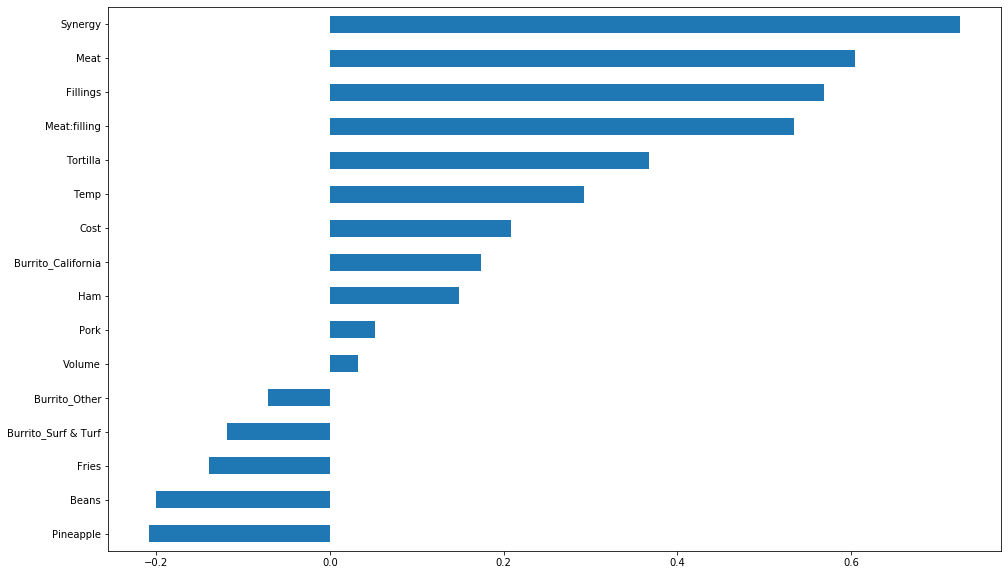

In [175]:
# Plot again the coefficients
coefficients = pd.Series(model.coef_[0], X_train_encoded[best_features].columns)
plt.figure(figsize=(16,10))
coefficients.sort_values().plot.barh();

### Model's test accuracy

In [0]:
X_test = test[features]
y_test = test[target]
X_test_encoded = encoder.transform(X_test)
X_test_imputed = imputer.transform(X_test_encoded[best_features])
X_test_scaled = scaler.transform(X_test_imputed)
y_pred = model.predict(X_test_scaled)

In [173]:
print('Test Accuracy', accuracy_score(y_test, y_pred))

Test Accuracy 0.7631578947368421


### Stretch Goals

My Stretch Goals were included in my work for the mandatory tasks:
- I did one-hot-encoding
- I plotted my coefficients
- I improved my model by selecting only meaningful features